In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Предполагая, что мы находимся на машине CUDA, это должно вывести устройство CUDA:

print(device)

cuda:0


In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [6]:
class FER2013Dataset(Dataset):
  def __init__(self, dataframe: pd.DataFrame, transform: A.Compose = None):
    self.__df = dataframe
    self.transform = transform
  
  def __len__(self) -> int:
    return len(self.__df)

  def __getitem__(self, idx: int) -> tuple[np.ndarray, int]:
    if torch.is_tensor(idx):
      idx = idx.tolist()

    label = self.__df.iloc[idx][0]
    image = np.fromstring(self.__df.iloc[idx][1], dtype=np.uint8, sep=' ').reshape(48, 48)

    if self.transform is not None:
      image = self.transform(image=image)["image"]

    return (image, label)

In [7]:
labeled_df = pd.read_csv('https://storage.googleapis.com/kaggle-competitions-data/kaggle-v2/3364/31151/compressed/train.csv.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1679674254&Signature=sKJ84oSm3WzhKr7t7%2FdrA53IyFFiaj%2FcKCECQwKJtvnMt8n5tBmX5AuImTyMNz0CIqku1Lz6KHctY4OTSwoVbjvkDruqYqmW4xyPR6tPD%2FjxEL8RCD4nFMFy%2B%2FG1MsZuJqIPBw3llbitSZ2g1sPDaDac8S8RpGQQ72cY3%2BDKvkuMV%2FO%2B%2FJgnhZ%2FRpTpMHA9hK8YcsyoZ2hDvW7XATaOCPJMXD3PuRipbFGey13ugQUAjhPnh4qaiW4nrKnca3WbSdHboTfa3FDgkr1eSDYWDbKM7ix57xn92fYgtvX%2BmBYVSo%2B2rhzqy2P5ymeKswxrd6OyAq6zfiOuoHzgTuhTsYQ%3D%3D&response-content-disposition=attachment%3B+filename%3Dtrain.csv.zip')
# labeled_df = pd.read_csv('/content/drive/MyDrive/datasets/fer2013/train.csv')

In [8]:
def split_dataset(df: pd.DataFrame, train: float = 0.8, validation: float = 0.2) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
  mask: bool = np.random.rand(len(df)) < train
  train_df: pd.DataFrame = df[mask]
  test_df: pd.DataFrame = df[~mask]
  mask_validation: bool = np.random.rand(len(train_df)) < validation
  val_df: pd.DataFrame = train_df[mask_validation]
  final_train_df: pd.DataFrame = train_df[~mask_validation]
  return (final_train_df, val_df, test_df)

In [9]:
(train_df, val_df, test_df) = split_dataset(labeled_df)

In [ ]:
transform_train = A.Compose([
    A.ShiftScaleRotate(
        shift_limit=0.05,
        scale_limit=0.05,
        rotate_limit=20, p=0.5),
    A.Normalize(mean=(0.5), std=(0.5)),
    ToTensorV2(),
])

transform_val = A.Compose([
    A.Normalize(mean=(0.5), std=(0.5)),
    ToTensorV2(),
])

batch_size = 4

trainset = FER2013Dataset(train_df, transform=transform_train)
trainloader = DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

validationset = FER2013Dataset(val_df, transform=transform_val)
validationloader = DataLoader(validationset, batch_size=batch_size,
                                          shuffle=False, num_workers=2)

testset = FER2013Dataset(test_df, transform=transform_val)
testloader = DataLoader(testset, batch_size=batch_size,
                                          shuffle=False, num_workers=2)

classes = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')

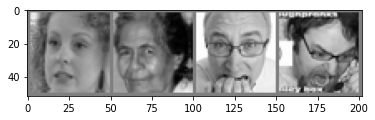

fear  neutral fear  angry


In [ ]:
# Show images

def imshow(img):
    img = img / 2 + 0.5     # обратная нормализация
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# выбираем случайные изображения
dataiter = iter(trainloader)
images, labels = next(dataiter)

# отображаем изображения
imshow(make_grid(images))
# подписываем лейблы
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [ ]:
class Model(nn.Module):
  def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 20, 5) # 22 x 22 after pooling
        self.conv2 = nn.Conv2d(20, 16, 5) # 9 x 9 after pooling
        self.pool = nn.MaxPool2d(2,2)
        self.fc1 = nn.Linear(16 * 9 * 9, 2048)
        self.fc2 = nn.Linear(2048, 1024)
        self.fc3 = nn.Linear(1024, 7) # 7 classes

  def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
model = Model().to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [ ]:
def one_training_epoch(model: Model, trainloader: DataLoader, criterion, optimizer: optim.Optimizer) -> float:
  model.train()
  running_loss = 0.0

  for i, data in enumerate(trainloader, 0):
      # получить входные данные; данные — это список [входов, меток]
      inputs, labels = data
      inputs, labels = inputs.to(device), labels.to(device)

      # обнулить градиенты параметров
      optimizer.zero_grad()

      # forward + backward + optimize
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

      # вывести статистику
      running_loss += loss.item()

  avg_loss = running_loss / (i + 1)
  return avg_loss

In [ ]:
epochs = 10
losses = []
vlosses = []

for epoch in range(epochs):
    # train
    avg_loss = one_training_epoch(model, trainloader, criterion, optimizer)
    losses.append(avg_loss)
    # validate
    model.eval()
    running_vloss = 0.0
    for i, vdata in enumerate(validationloader):
        vinputs, vlabels = vdata
        vinputs, vlabels = vinputs.to(device), vlabels.to(device)
        voutputs = model(vinputs)
        vloss = criterion(voutputs, vlabels)
        running_vloss += vloss.item()
    vlosses.append(running_vloss / (i + 1))

    print(f'EPOCH {epoch + 1}, TRAIN_LOSS: {losses[epoch]:.3f}, VAL_LOSS: {vlosses[epoch]:.3f}')

EPOCH 1, TRAIN_LOSS: 1.739, VAL_LOSS: 1.581
EPOCH 2, TRAIN_LOSS: 1.609, VAL_LOSS: 1.481
EPOCH 3, TRAIN_LOSS: 1.503, VAL_LOSS: 1.392
EPOCH 4, TRAIN_LOSS: 1.410, VAL_LOSS: 1.298
EPOCH 5, TRAIN_LOSS: 1.325, VAL_LOSS: 1.253
EPOCH 6, TRAIN_LOSS: 1.248, VAL_LOSS: 1.231
EPOCH 7, TRAIN_LOSS: 1.181, VAL_LOSS: 1.206


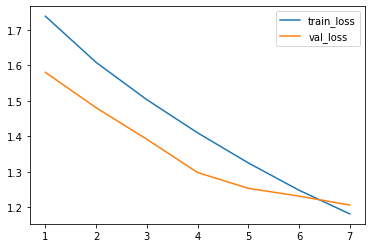

In [ ]:
# show train vs validation losses plot
plt.plot([i + 1 for i in range(epochs)], losses, label = "train_loss")
plt.plot([i + 1 for i in range(epochs)], vlosses, label = "val_loss")
plt.legend()
plt.show()

In [ ]:
for i in range(epochs):
  print(f'EPOCH {i + 1}, TRAIN_LOSS: {losses[i]:.3f}, VAL_LOSS: {vlosses[i]:.3f}')

EPOCH 1, TRAIN_LOSS: 1.735, VAL_LOSS: 1.589
EPOCH 2, TRAIN_LOSS: 1.590, VAL_LOSS: 1.448
EPOCH 3, TRAIN_LOSS: 1.487, VAL_LOSS: 1.373
EPOCH 4, TRAIN_LOSS: 1.395, VAL_LOSS: 1.342
EPOCH 5, TRAIN_LOSS: 1.315, VAL_LOSS: 1.256
EPOCH 6, TRAIN_LOSS: 1.243, VAL_LOSS: 1.300
EPOCH 7, TRAIN_LOSS: 1.171, VAL_LOSS: 1.206
EPOCH 8, TRAIN_LOSS: 1.097, VAL_LOSS: 1.263
EPOCH 9, TRAIN_LOSS: 1.031, VAL_LOSS: 1.318
EPOCH 10, TRAIN_LOSS: 0.957, VAL_LOSS: 1.217
EPOCH 11, TRAIN_LOSS: 0.883, VAL_LOSS: 1.247
EPOCH 12, TRAIN_LOSS: 0.821, VAL_LOSS: 1.346
EPOCH 13, TRAIN_LOSS: 0.756, VAL_LOSS: 1.332
EPOCH 14, TRAIN_LOSS: 0.712, VAL_LOSS: 1.347
EPOCH 15, TRAIN_LOSS: 0.652, VAL_LOSS: 1.410


In [ ]:
# save model

PATH = './fer_model.pth'
torch.save(model.state_dict(), PATH)

In [ ]:
correct = 0
total = 0
# поскольку мы не обучаемся, нам не нужно вычислять градиенты для наших выходных данных.
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        # вычисляем выходные данные, прогоняя изображения по сети
        outputs = model(images)
        # класс с наибольшей энергией - это то, что мы выбираем в качестве прогноза
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the {len(testset)} test images: {100 * correct // total} %')

Accuracy of the network on the 5742 test images: 52 %
